In [221]:
from skimage.metrics import peak_signal_noise_ratio
import tensorflow as tf
import os
import tensorflow.image as tf_image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, concatenate
from tensorflow.keras import layers,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
import shutil
import random
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
import torch

# Check if CUDA (GPU support) is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Get the name of the current GPU
    current_gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Name of the current GPU: {current_gpu_name}")
else:
    print("CUDA is not available. Using CPU.")


Number of GPUs available: 2
Name of the current GPU: NVIDIA RTX A5000


In [222]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [34]:
#tf.debugging.set_log_device_placement(False)

In [35]:
# import zipfile
# import os

# # Path to the ZIP file
# zip_file_path = 'data.zip'

# # Directory where you want to extract the files
# extract_to_directory = 'extracted_data'

# # Create the directory if it doesn't exist
# os.makedirs(extract_to_directory, exist_ok=True)

# # Extract the files
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_directory)

# # List the extracted files
# extracted_files = os.listdir(extract_to_directory)
# print("Files extracted successfully:")
# print(extracted_files)

In [42]:
extract_to_directory = 'extracted_data'
blurred_dir = os.path.join(extract_to_directory, 'data', 'Blurred_images')
clear_dir=os.path.join(extract_to_directory, 'data', 'clear_images')
print("Path to Blurred_images folder:", blurred_dir)

Path to Blurred_images folder: extracted_data/data/Blurred_images


In [37]:
blurred_dir

'extracted_data/data/Blurred_images'

In [38]:
clear_dir

'extracted_data/data/clear_images'

# Train val split:

In [39]:
# src_blurred_dir = 'extracted_data/data/Blurred_images'
# src_clear_dir = 'extracted_data/data/clear_images'
# train_blurred_dir = 'train/blurred'
# train_clear_dir = 'train/clear'
# val_blurred_dir = 'val/blurred'
# val_clear_dir = 'val/clear'

In [40]:
# os.makedirs(train_blurred_dir, exist_ok=True)
# os.makedirs(train_clear_dir, exist_ok=True)
# os.makedirs(val_blurred_dir, exist_ok=True)
# os.makedirs(val_clear_dir, exist_ok=True)

In [41]:
# subfolders = [f.path for f in os.scandir(src_blurred_dir) if f.is_dir()]

# for subfolder in tqdm(subfolders):
#     subfolder_name = os.path.basename(subfolder)
#     blurred_files = os.listdir(os.path.join(src_blurred_dir, subfolder_name))
#     clear_files = os.listdir(os.path.join(src_clear_dir, subfolder_name))
    
#     # Shuffle the files
#     random.shuffle(blurred_files)
#     random.shuffle(clear_files)
    
#     # Calculate the split indices
#     split_idx_blurred = int(0.75 * len(blurred_files))
#     split_idx_clear = int(0.75 * len(clear_files))
    
#     # Create subfolder in train and val directories
#     os.makedirs(os.path.join(train_blurred_dir, subfolder_name), exist_ok=True)
#     os.makedirs(os.path.join(train_clear_dir, subfolder_name), exist_ok=True)
#     os.makedirs(os.path.join(val_blurred_dir, subfolder_name), exist_ok=True)
#     os.makedirs(os.path.join(val_clear_dir, subfolder_name), exist_ok=True)
    
#     # Copy files to train and val directories
#     for i, file in enumerate(blurred_files):
#         src_path = os.path.join(src_blurred_dir, subfolder_name, file)
#         if i < split_idx_blurred:
#             dst_path = os.path.join(train_blurred_dir, subfolder_name, file)
#         else:
#             dst_path = os.path.join(val_blurred_dir, subfolder_name, file)
#         shutil.copy(src_path, dst_path)
    
#     for i, file in enumerate(clear_files):
#         src_path = os.path.join(src_clear_dir, subfolder_name, file)
#         if i < split_idx_clear:
#             dst_path = os.path.join(train_clear_dir, subfolder_name, file)
#         else:
#             dst_path = os.path.join(val_clear_dir, subfolder_name, file)
#         shutil.copy(src_path, dst_path)

# Unet Architecture

In [5]:

def UNet1(input_shape):
#     def UNet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Down sampling
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv5)

    # Up sampling
    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# Unet with Batch Normalization (used for model)

In [151]:
def UNet2(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Down sampling
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    # Up sampling
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [152]:
model=UNet2(input_shape = (256, 448, 3)) #creating model instance

In [153]:
def psnr(y_true, y_pred):
    return tf_image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    
    return tf_image.ssim(y_true, y_pred, max_val=1.0)

In [154]:
model.compile(optimizer='adam', loss='mse',metrics=['mse',psnr])

In [155]:
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 256, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_247 (Conv2D) │ (None, 256, 448,  │        896 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 448,  │        128 │ conv2d_247[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_248 (Conv2D) │ (None, 256, 448,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 128, 224,  │          0 │ conv2d_248[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_249 (Conv2D) │ (None, 128, 224,  │     18,496 │ max_pooling2d_52… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 224,  │        256 │ conv2d_249[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_250 (Conv2D) │ (None, 128, 224,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_53    │ (None, 64, 112,   │          0 │ conv2d_250[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_251 (Conv2D) │ (None, 64, 112,   │     73,856 │ max_pooling2d_53… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_252 (Conv2D) │ (None, 64, 112,   │    147,584 │ conv2d_251[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 32, 56,    │          0 │ conv2d_252[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_253 (Conv2D) │ (None, 32, 56,    │    295,168 │ max_pooling2d_54… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 56,    │      1,024 │ conv2d_253[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_254 (Conv2D) │ (None, 32, 56,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 16, 28,    │          0 │ conv2d_254[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_255 (Conv2D) │ (None, 16, 28,    │  1,180,160 │ max_pooling2d_55

 Total params: 7,763,491 (29.62 MB)

 Trainable params: 7,761,827 (29.61 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [83]:
train_blurred='train/blurred'
train_clear="train/clear"
val_blurred='val/blurred'
val_clear='val/clear'

In [84]:
# Define data generators
data_gen_args = dict(rescale=1./255,horizontal_flip=True)
blurred_datagen = ImageDataGenerator(**data_gen_args)
clear_datagen = ImageDataGenerator(**data_gen_args)

blurred_datagen_val = ImageDataGenerator(**data_gen_args)
clear_datagen_val = ImageDataGenerator(**data_gen_args)

# Training:

In [223]:
# #from losses import SSIM_Loss
# class SSIM_Loss(tf.keras.losses.Loss):
#     def __init__(self):
#         super(SSIM_Loss, self).__init__()

#     def call(self, y_true, y_pred):
#         return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
# # Define input shape
# input_shape = (256, 448, 3)



# # Create generators for blurred and clear images for test
# blurred_generator = blurred_datagen.flow_from_directory(
#     train_blurred, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)
# clear_generator = clear_datagen.flow_from_directory(
#     train_clear, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)


# # Create generators for blurred and clear images for validation
# blurred_generator_val = blurred_datagen_val.flow_from_directory(
#     val_blurred, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)
# clear_generator_val = clear_datagen_val.flow_from_directory(
#     val_clear, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)


# # Define a custom generator function
# def train_generator():
#     while True:
#         blurred_batch = blurred_generator.__next__()
#         clear_batch = clear_generator.__next__()
#         yield (blurred_batch, clear_batch)
        
# # Define a custom generator function
# def val_generator():
#     while True:
#         blurred_batch = blurred_generator_val.__next__()
#         clear_batch = clear_generator_val.__next__()
#         yield (blurred_batch, clear_batch)

# # Define loss functions
# mse_loss = MeanSquaredError()
# mae_loss = MeanAbsoluteError()
# ssim_loss = SSIM_Loss()

# # Define a combined loss function
# def combined_loss(y_true, y_pred):
#     mse = mse_loss(y_true, y_pred)
#     mae = mae_loss(y_true, y_pred)
#     ssim = ssim_loss(y_true, y_pred)
#     return 1*mse + 0.7 * mae + 0.8 * (1 - ssim)

# import math

# # Calculate the number of steps per epoch for training
# num_train_samples = len(blurred_generator.filepaths)
# steps_per_epoch_train = math.ceil(num_train_samples / blurred_generator.batch_size)

# # Calculate the number of validation steps
# num_val_samples = len(blurred_generator_val.filepaths)
# validation_steps = math.ceil(num_val_samples / blurred_generator_val.batch_size)

# # Define callbacks
# #checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# # Compile the model
# optimizer = Adam(learning_rate=1e-2)
# model.compile(optimizer=optimizer, loss=mse_loss, metrics=[psnr,mse_loss, mae_loss, ssim_loss])

# # Train the model
# history = model.fit(train_generator(),
#                     steps_per_epoch=steps_per_epoch_train,
#                     epochs=5,
#                     validation_data=val_generator(),
#                     validation_steps=validation_steps,
#                     callbacks=[early_stop, reduce_lr],
#                     verbose=1)

In [224]:
# #from losses import SSIM_Loss
# class SSIM_Loss(tf.keras.losses.Loss):
#     def __init__(self):
#         super(SSIM_Loss, self).__init__()

#     def call(self, y_true, y_pred):
#         return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
# # Define input shape
# input_shape = (256, 448, 3)



# # Create generators for blurred and clear images for test
# blurred_generator = blurred_datagen.flow_from_directory(
#     blurred_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)
# clear_generator = clear_datagen.flow_from_directory(
#     clear_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)



# # Define a custom generator function
# def train_generator():
#     while True:
#         blurred_batch = blurred_generator.__next__()
#         clear_batch = clear_generator.__next__()
#         yield (blurred_batch, clear_batch)
        


# # Define loss functions
# mse_loss = MeanSquaredError()
# mae_loss = MeanAbsoluteError()
# ssim_loss = SSIM_Loss()

# # Define a combined loss function
# def combined_loss(y_true, y_pred):
#     mse = mse_loss(y_true, y_pred)
#     mae = mae_loss(y_true, y_pred)
#     ssim = ssim_loss(y_true, y_pred)
#     return 1*mse + 0.7 * mae + 0.8 * (1 - ssim)

# import math

# # Calculate the number of steps per epoch for training
# num_train_samples = len(blurred_generator.filepaths)
# steps_per_epoch_train = math.ceil(num_train_samples / blurred_generator.batch_size)


# # Define callbacks
# #checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# early_stop = EarlyStopping(monitor='mse_loss', patience=10, restore_best_weights=True,mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='mse_loss', factor=0.2, patience=5, min_lr=1e-7,mode='min')

# # Compile the model
# optimizer = Adam(learning_rate=1e-2)
# model.compile(optimizer=optimizer, loss=mse_loss, metrics=[psnr,mse_loss, mae_loss, ssim_loss])

# # Train the model
# history = model.fit(train_generator(),
#                     steps_per_epoch=steps_per_epoch_train,
#                     epochs=5,
#                     callbacks=[early_stop, reduce_lr],
#                     verbose=1)

In [225]:
# #from losses import SSIM_Loss
# class SSIM_Loss(tf.keras.losses.Loss):
#     def __init__(self):
#         super(SSIM_Loss, self).__init__()

#     def call(self, y_true, y_pred):
#         return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
# # Define input shape
# input_shape = (256, 448, 3)



# # Create generators for blurred and clear images for test
# blurred_generator = blurred_datagen.flow_from_directory(
#     blurred_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)
# clear_generator = clear_datagen.flow_from_directory(
#     clear_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)



# # Define a custom generator function
# def train_generator():
#     while True:
#         blurred_batch = blurred_generator.__next__()
#         clear_batch = clear_generator.__next__()
#         yield (blurred_batch, clear_batch)
        


# # Define loss functions
# mse_loss = MeanSquaredError()
# mae_loss = MeanAbsoluteError()
# ssim_loss = SSIM_Loss()

# # Define a combined loss function
# def combined_loss(y_true, y_pred):
#     mse = mse_loss(y_true, y_pred)
#     mae = mae_loss(y_true, y_pred)
#     ssim = ssim_loss(y_true, y_pred)
#     return 1*mse + 0.7 * mae + 0.8 * (1 - ssim)

# import math

# # Calculate the number of steps per epoch for training
# num_train_samples = len(blurred_generator.filepaths)
# steps_per_epoch_train = math.ceil(num_train_samples / blurred_generator.batch_size)


# # Define callbacks
# #checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# early_stop = EarlyStopping(monitor='mse_loss', patience=10, restore_best_weights=True,)
# reduce_lr = ReduceLROnPlateau(monitor='mse_loss', factor=0.2, patience=5, min_lr=1e-7)

# # Compile the model
# optimizer = Adam(learning_rate=1e-2)
# model.compile(optimizer=optimizer, loss=mse_loss, metrics=[psnr,mse_loss, mae_loss, ssim_loss])

# # # Train the model
# # history = model.fit(train_generator(),
# #                     steps_per_epoch=steps_per_epoch_train,
# #                     epochs=20,
# #                     callbacks=[early_stop, reduce_lr],
# #                     verbose=1)

In [226]:
# import os
# import pandas as pd

# clear_images = [os.path.join('custom_test/sharp', f) for f in os.listdir('custom_test/sharp')]
# clear_df = pd.DataFrame({'file_path': clear_images})
# clear_generator_val = clear_datagen_val.flow_from_dataframe(
#     dataframe=clear_df,
#     x_col='file_path',
#     y_col=None,
#     target_size=(256, 448),
#     batch_size=32,
#     class_mode=None,
#     seed=42
# )
# blurred_images = [os.path.join('custom_test/blur', f) for f in os.listdir('custom_test/blur')]
# blurred_df = pd.DataFrame({'file_path': blurred_images})

# blurred_generator_val = blurred_datagen_val.flow_from_dataframe(
#     dataframe=blurred_df,
#     x_col='file_path',
#     y_col=None,
#     target_size=(256, 448),
#     batch_size=32,
#     class_mode=None,
#     seed=42
# )
# def val_generator():
#     while True:
#         blurred_batch = blurred_generator_val.__next__()
#         clear_batch = clear_generator_val.__next__()
#         yield (blurred_batch, clear_batch)

In [60]:
os.listdir('custom_test')

['blur', 'sharp']

In [227]:
# #from losses import SSIM_Loss

# class SSIM_Loss(tf.keras.losses.Loss):
#     def __init__(self):
#         super(SSIM_Loss, self).__init__()

#     def call(self, y_true, y_pred):
#         return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

# # Define input shape
# input_shape = (256, 448, 3)

# # Create generators for blurred and clear images for training
# blurred_generator = blurred_datagen.flow_from_directory(
#     blurred_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)

# clear_generator = clear_datagen.flow_from_directory(
#     clear_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)

# blurred_generator_val = blurred_datagen_val.flow_from_directory(
#     './custom_test/blur', target_size=(256, 448), batch_size=32, class_mode=None, seed=42)

# clear_generator_val = clear_datagen_val.flow_from_directory(
#     './custom_test/sharp', target_size=(256, 448), batch_size=32, class_mode=None, seed=42)

# # Define a custom generator function for training
# def train_generator():
#     while True:
#         blurred_batch = blurred_generator.__next__()
#         clear_batch = clear_generator.__next__()
#         yield (blurred_batch, clear_batch)

# # Define a custom generator function for validation data
# def val_generator():
#     while True:
#         blurred_batch = blurred_generator_val.__next__()
#         clear_batch = clear_generator_val.__next__()
#         yield (blurred_batch, clear_batch)

# # Define loss functions
# mse_loss = MeanSquaredError()
# mae_loss = MeanAbsoluteError()
# ssim_loss = SSIM_Loss()

# # Define a combined loss function
# def combined_loss(y_true, y_pred):
#     mse = mse_loss(y_true, y_pred)
#     mae = mae_loss(y_true, y_pred)
#     ssim = ssim_loss(y_true, y_pred)
#     return 1 * mse + 0.7 * mae + 0.8 * (1 - ssim)

# import math

# # Calculate the number of steps per epoch for training
# num_train_samples = len(blurred_generator.filepaths)
# steps_per_epoch_train = math.ceil(num_train_samples / blurred_generator.batch_size)

# # Calculate the number of validation steps
# num_val_samples = len(blurred_generator_val.filepaths)
# validation_steps = math.ceil(num_val_samples / blurred_generator_val.batch_size)

# # Define callbacks
# #checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# # Compile the model
# optimizer = Adam(learning_rate=1e-2)
# model.compile(optimizer=optimizer, loss=mse_loss, metrics=[psnr, mse_loss, mae_loss, ssim_loss])

# # Train the model
# # history = model.fit(train_generator(),
# #                     steps_per_epoch=steps_per_epoch_train,
# #                     epochs=20,
# #                     validation_data=val_generator(),
# #                     validation_steps=validation_steps,
# #                     callbacks=[early_stop, reduce_lr],
# #                     verbose=1)

# final Training code:

In [159]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from losses import SSIM_Loss
class SSIM_Loss(tf.keras.losses.Loss):
    def __init__(self):
        super(SSIM_Loss, self).__init__()

    def call(self, y_true, y_pred):
        return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
# Define input shape
input_shape = (256, 448, 3)



# Create generators for blurred and clear images for test
blurred_generator = blurred_datagen.flow_from_directory(
    blurred_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)
clear_generator = clear_datagen.flow_from_directory(
    clear_dir, target_size=(256, 448), batch_size=64, class_mode=None, seed=42)



# Define a custom generator function
def train_generator():
    while True:
        blurred_batch = blurred_generator.__next__()
        clear_batch = clear_generator.__next__()
        yield (blurred_batch, clear_batch)
        


# Define loss functions
mse_loss = MeanSquaredError()
mae_loss = MeanAbsoluteError()
ssim_loss = SSIM_Loss()

# Define a combined loss function
def combined_loss(y_true, y_pred):
    mse = mse_loss(y_true, y_pred)
    mae = mae_loss(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return 1*mse + 0.7 * mae + 0.8 * (1 - ssim)

import math

# Calculate the number of steps per epoch for training
num_train_samples = len(blurred_generator.filepaths)
steps_per_epoch_train = math.ceil(num_train_samples / blurred_generator.batch_size)


# Define callbacks
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='mse_loss', patience=10, restore_best_weights=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='mse_loss', factor=0.2, patience=5, min_lr=1e-7,mode='min')

# Compile the model
optimizer = Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss=mse_loss, metrics=[psnr,mse_loss, mae_loss, ssim_loss])


# Define paths to validation images
validation_blurred_paths = ['custom_test/blur/' + filename for filename in os.listdir('custom_test/blur')]
validation_clear_paths = ['custom_test/sharp/' + filename for filename in os.listdir('custom_test/sharp')]


# Define a custom generator function for validation data
def validation_generator():
    while True:
        for i in range(num_val_samples // batch_size):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            blurred_batch = load_images(validation_blurred_paths[start_idx:end_idx])
            clear_batch = load_images(validation_clear_paths[start_idx:end_idx])
            yield (blurred_batch, clear_batch)

# Define function to load images
def load_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(256, 448))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)

# Define batch size
batch_size = 64

# Get number of validation samples
num_val_samples = len(validation_blurred_paths)

# Train the model
history = model.fit(train_generator(),
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=25,
                    validation_data=validation_generator(),
                    validation_steps=num_val_samples // batch_size,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)


Found 24000 images belonging to 240 classes.
Found 24000 images belonging to 240 classes.
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 218s 568ms/step - loss: 0.0033 - mean_absolute_error: 0.0387 - mean_squared_error: 0.0033 - psnr: 25.8516 - ssim__loss_11: 0.1704 - val_loss: 0.0036 - val_mean_absolute_error: 0.0443 - val_mean_squared_error: 0.0036 - val_psnr: 24.5641 - val_ssim__loss_11: 0.1390 - learning_rate: 0.0100
Epoch 2/25


/home/23m1526/.local/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `mse_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error,psnr,ssim__loss_11,val_loss,val_mean_absolute_error,val_mean_squared_error,val_psnr,val_ssim__loss_11
  current = self.get_monitor_value(logs)
/home/23m1526/.local/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `mse_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error,psnr,ssim__loss_11,val_loss,val_mean_absolute_error,val_mean_squared_error,val_psnr,val_ssim__loss_11,learning_rate.
  callback.on_epoch_end(epoch, logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 226s 602ms/step - loss: 0.0018 - mean_absolute_error: 0.0284 - mean_squared_error: 0.0018 - psnr: 28.3842 - ssim__loss_11: 0.1265 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257 - val_mean_squared_error: 0.0012 - val_psnr: 29.2783 - val_ssim__loss_11: 0.0864 - learning_rate: 0.0100
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 242s 645ms/step - loss: 0.0014 - mean_absolute_error: 0.0251 - mean_squared_error: 0.0014 - psnr: 29.7597 - ssim__loss_11: 0.1020 - val_loss: 0.0020 - val_mean_absolute_error: 0.0348 - val_mean_squared_error: 0.0020 - val_psnr: 27.0008 - val_ssim__loss_11: 0.1058 - learning_rate: 0.0100
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 576ms/step - loss: 0.0011 - mean_absolute_error: 0.0222 - mean_squared_error: 0.0011 - psnr: 30.8825 - ssim__loss_11: 0.0861 - val_loss: 0.0020 - val_mean_absolute_error: 0.0330 - val_mean_squared_error: 0.0020 - val_psnr: 27.1514 - val_ssim__loss_11: 0.0922 - learning_rate: 0.0100
Epoch 5/25
375/375 ━━━━━━━━

## Saving the model and logs

In [236]:
model.save_weights('unet_final.weights.h5')

In [237]:
import pickle
with open('history_final_unet.pkl','wb') as f:
    pickle.dump(history.history,f)

## Loading the model/checkpoint and logs 

In [238]:
model1=UNet2(input_shape)
model1.load_weights('unet_final.weights.h5')

In [239]:
with open('history_final_unet.pkl','rb') as f:
    loaded_history=pickle.load(f)

In [240]:
import json
# Save the dictionary to a JSON file
with open('History_final.json', "w") as json_file:
    json.dump(loaded_history, json_file)

# Training curves

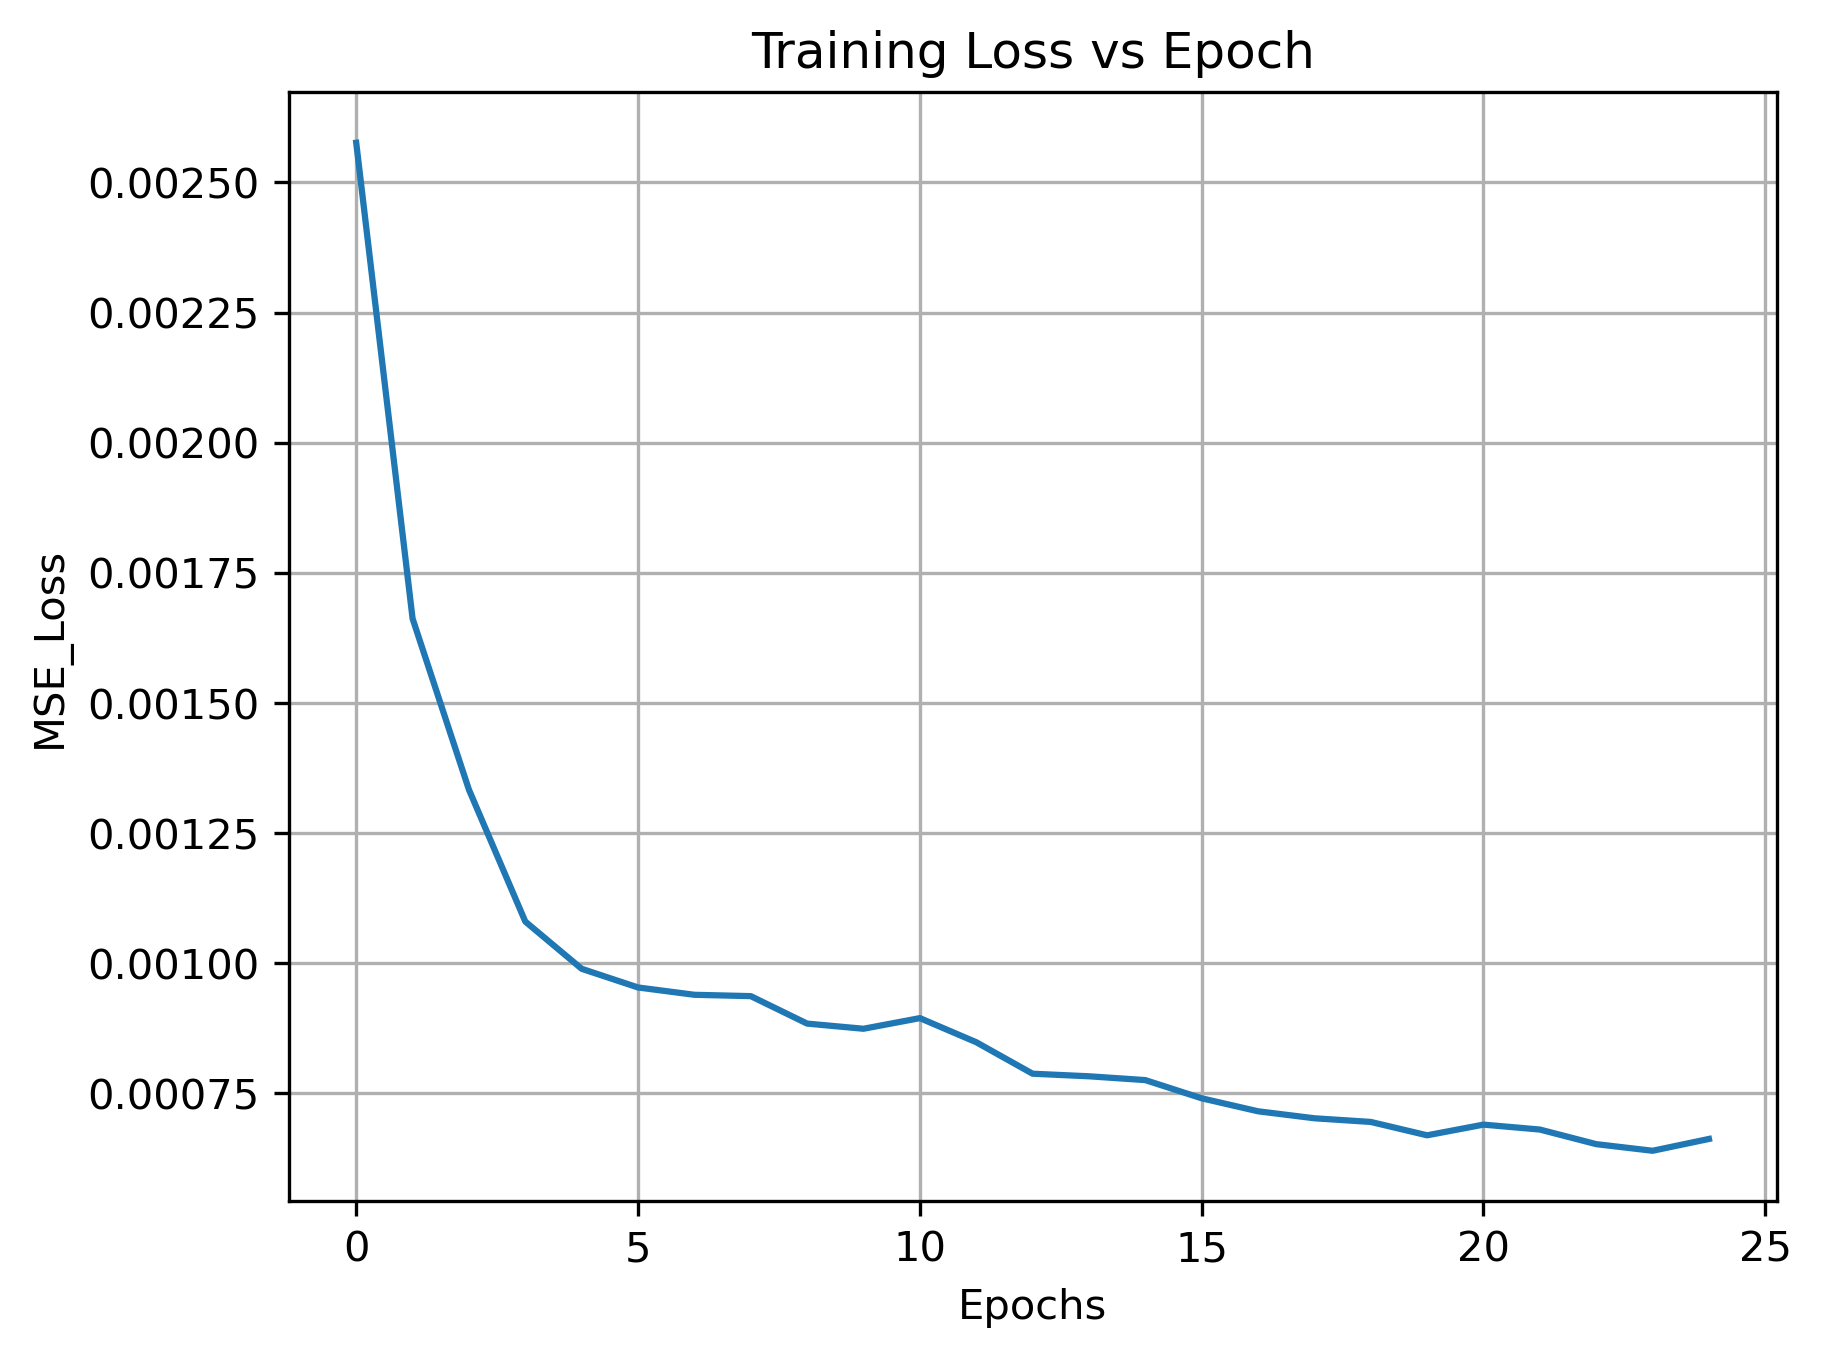

In [209]:
plt.figure(dpi=300)
plt.grid()
plt.plot(history.history['loss'])
plt.title('Training Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('MSE_Loss')
plt.savefig('Training_loss.png')
#plt.plot(np.array(history.history['val_loss'])/100)

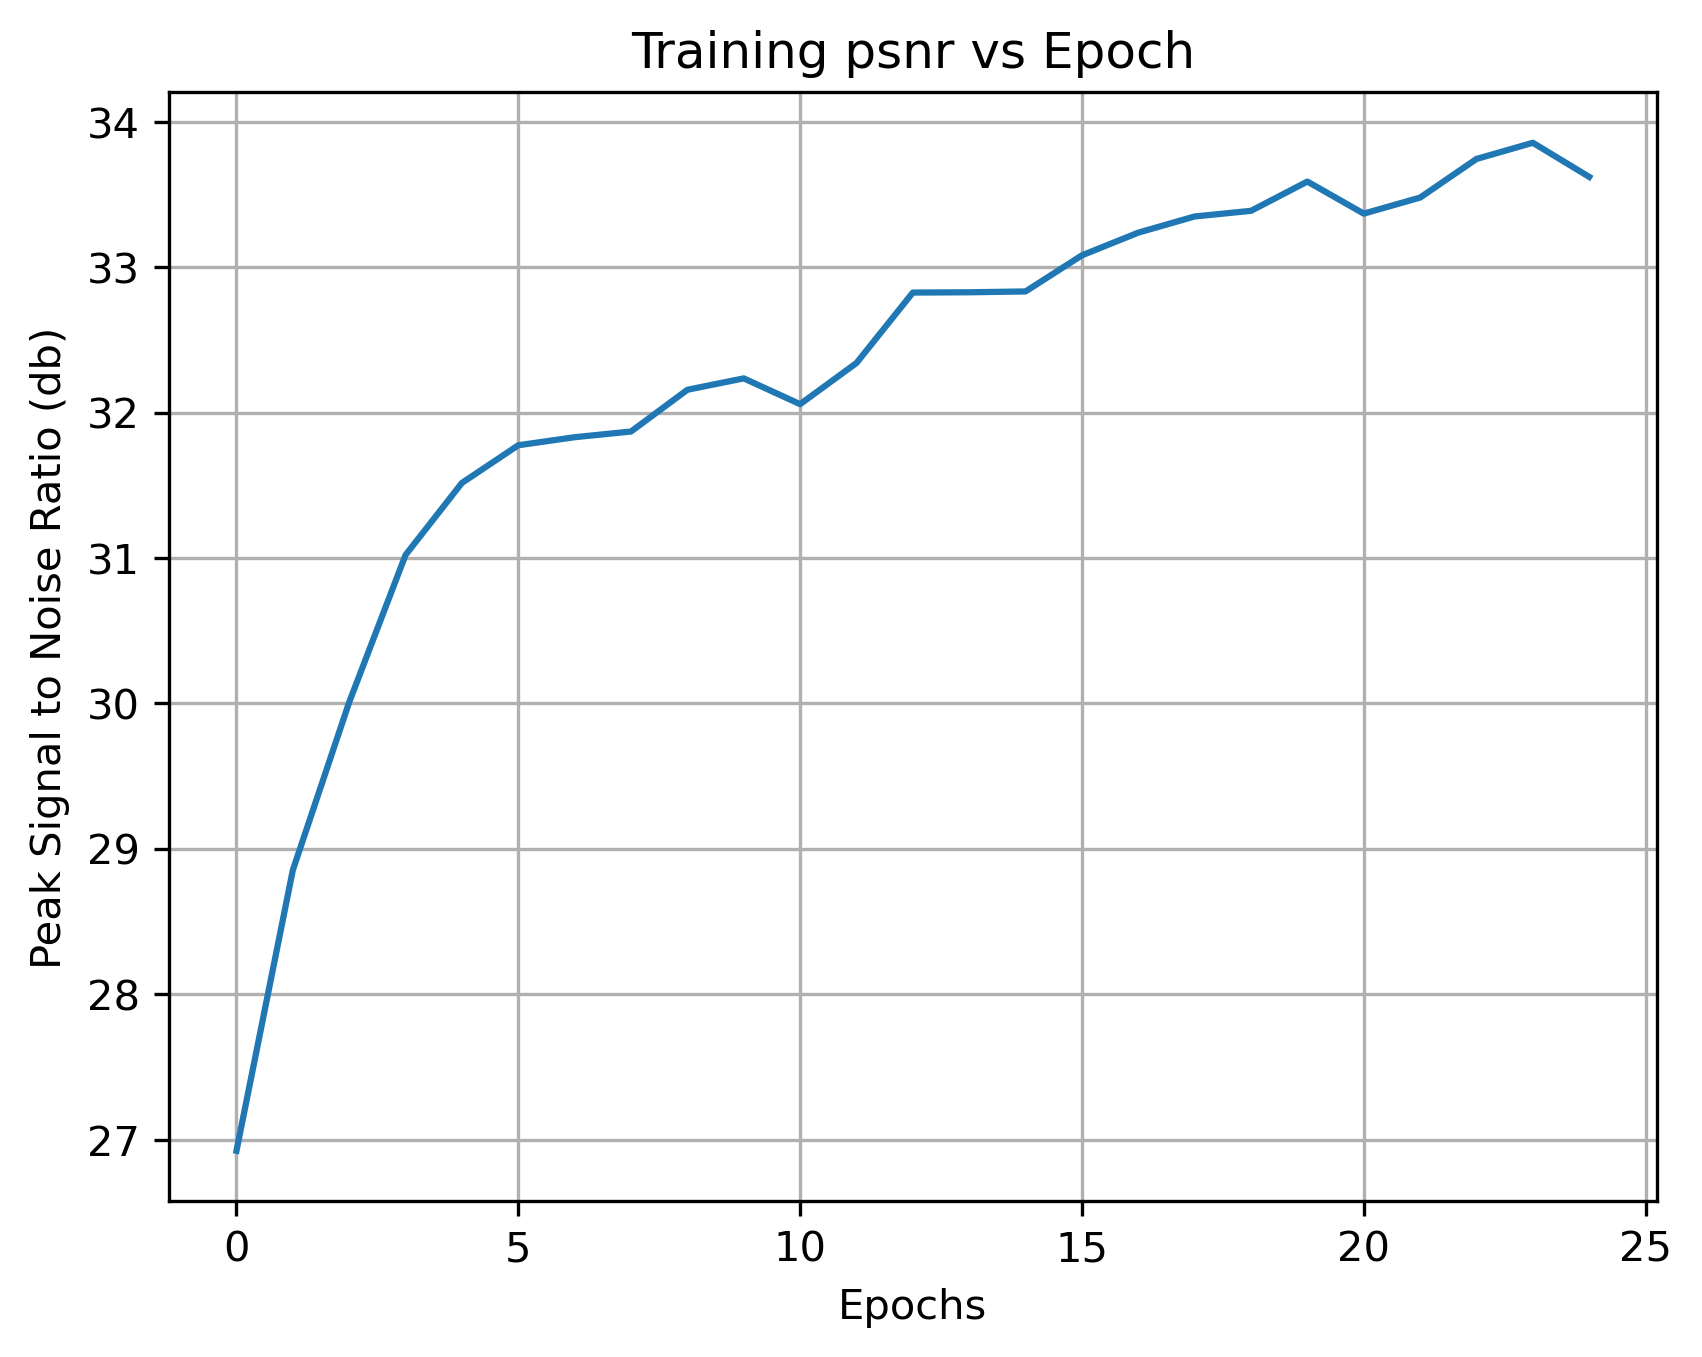

In [213]:
plt.figure(dpi=300)
plt.grid()
plt.plot(history.history['psnr'])
plt.title('Training psnr vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Peak Signal to Noise Ratio (db)')
plt.savefig('training_psnr.png')

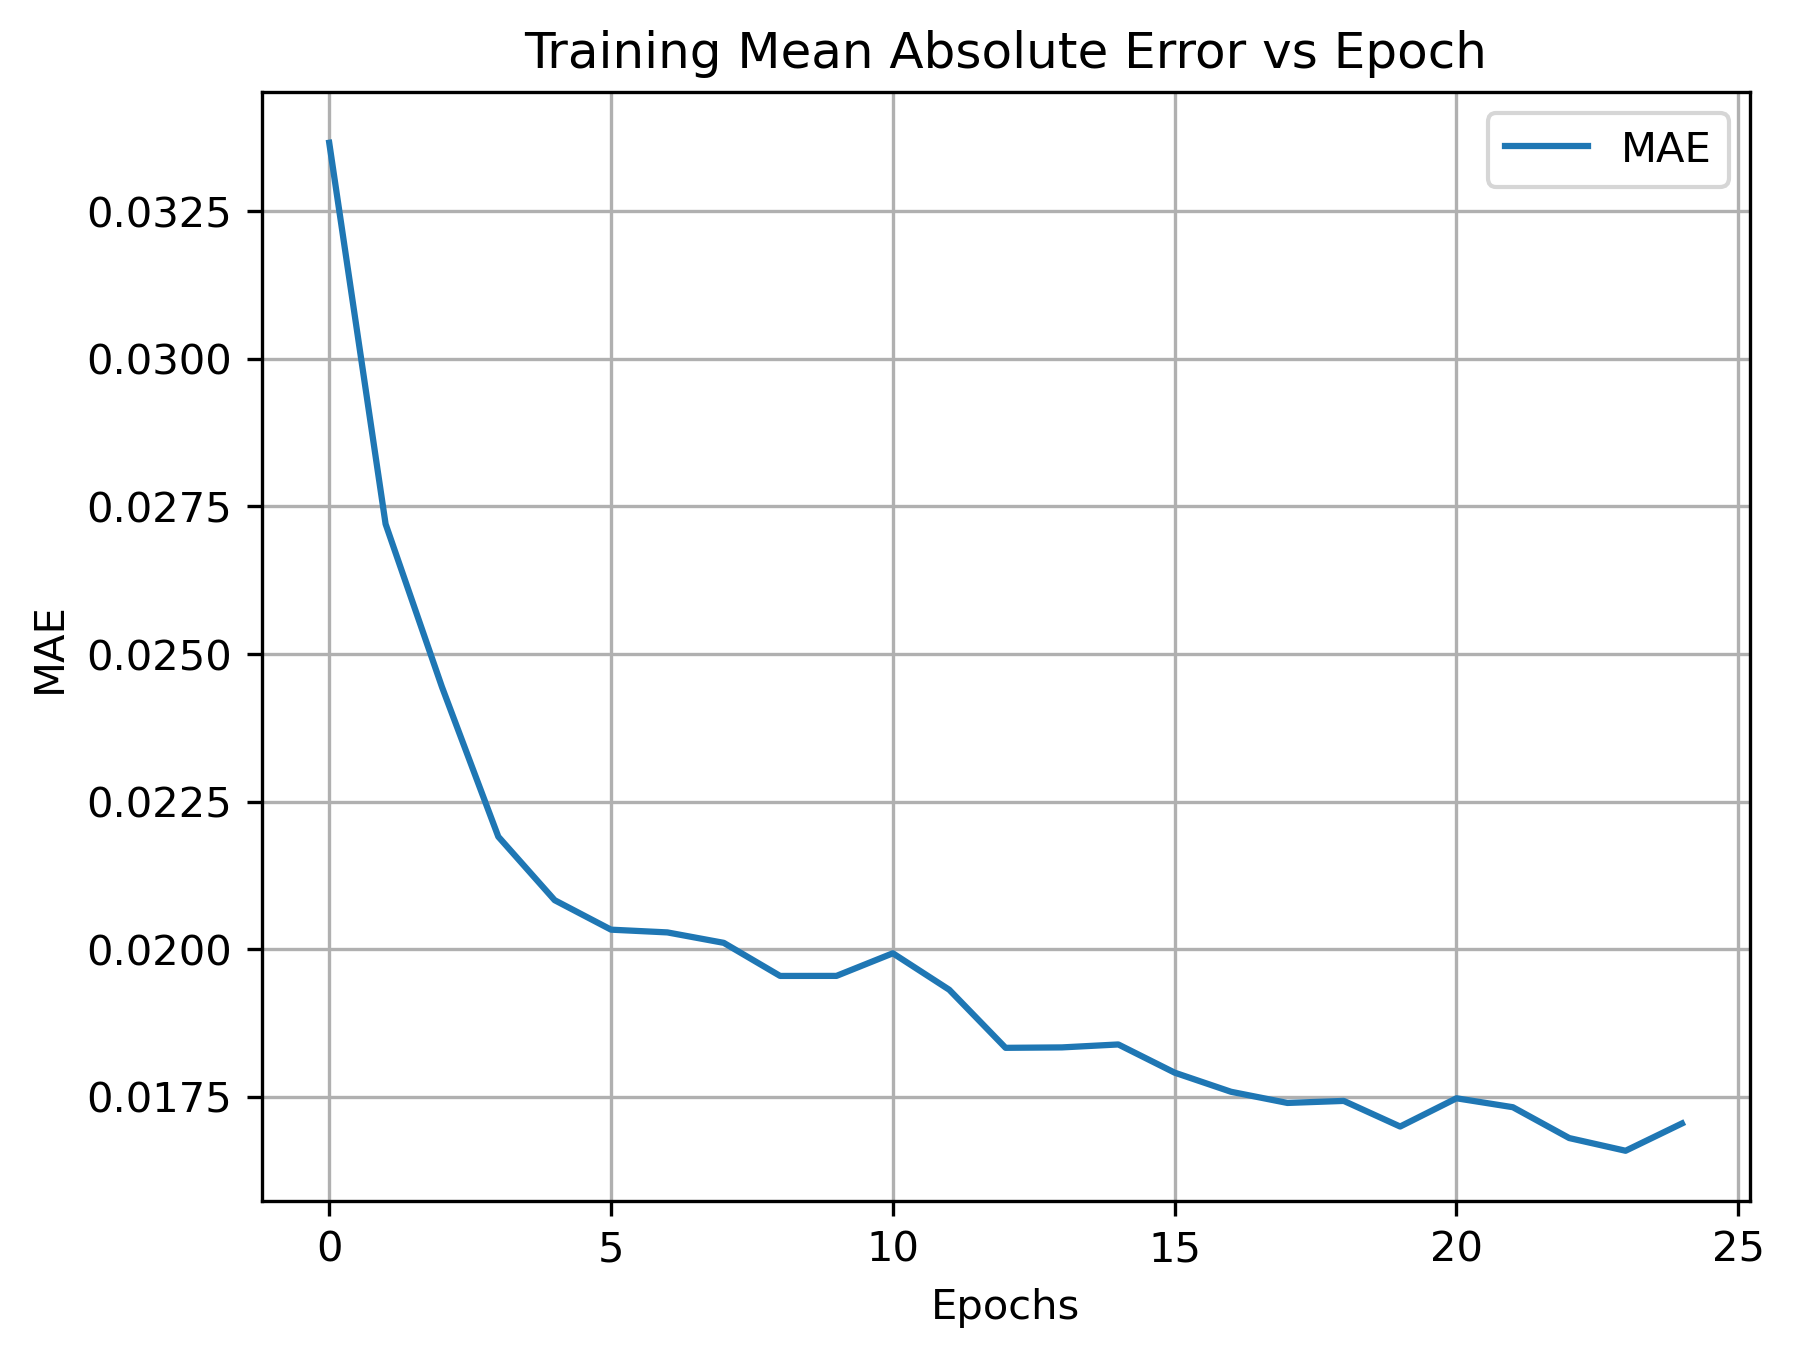

In [219]:
plt.figure(dpi=300)
plt.grid()
plt.plot(history.history['mean_absolute_error'],label='MAE')
# plt.plot(history.history['mean_squared_error'],label='MSE')
# plt.plot(history.history['ssim__loss_11'],label='ssim')
plt.title('Training Mean Absolute Error vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.savefig('MAE_training.png')

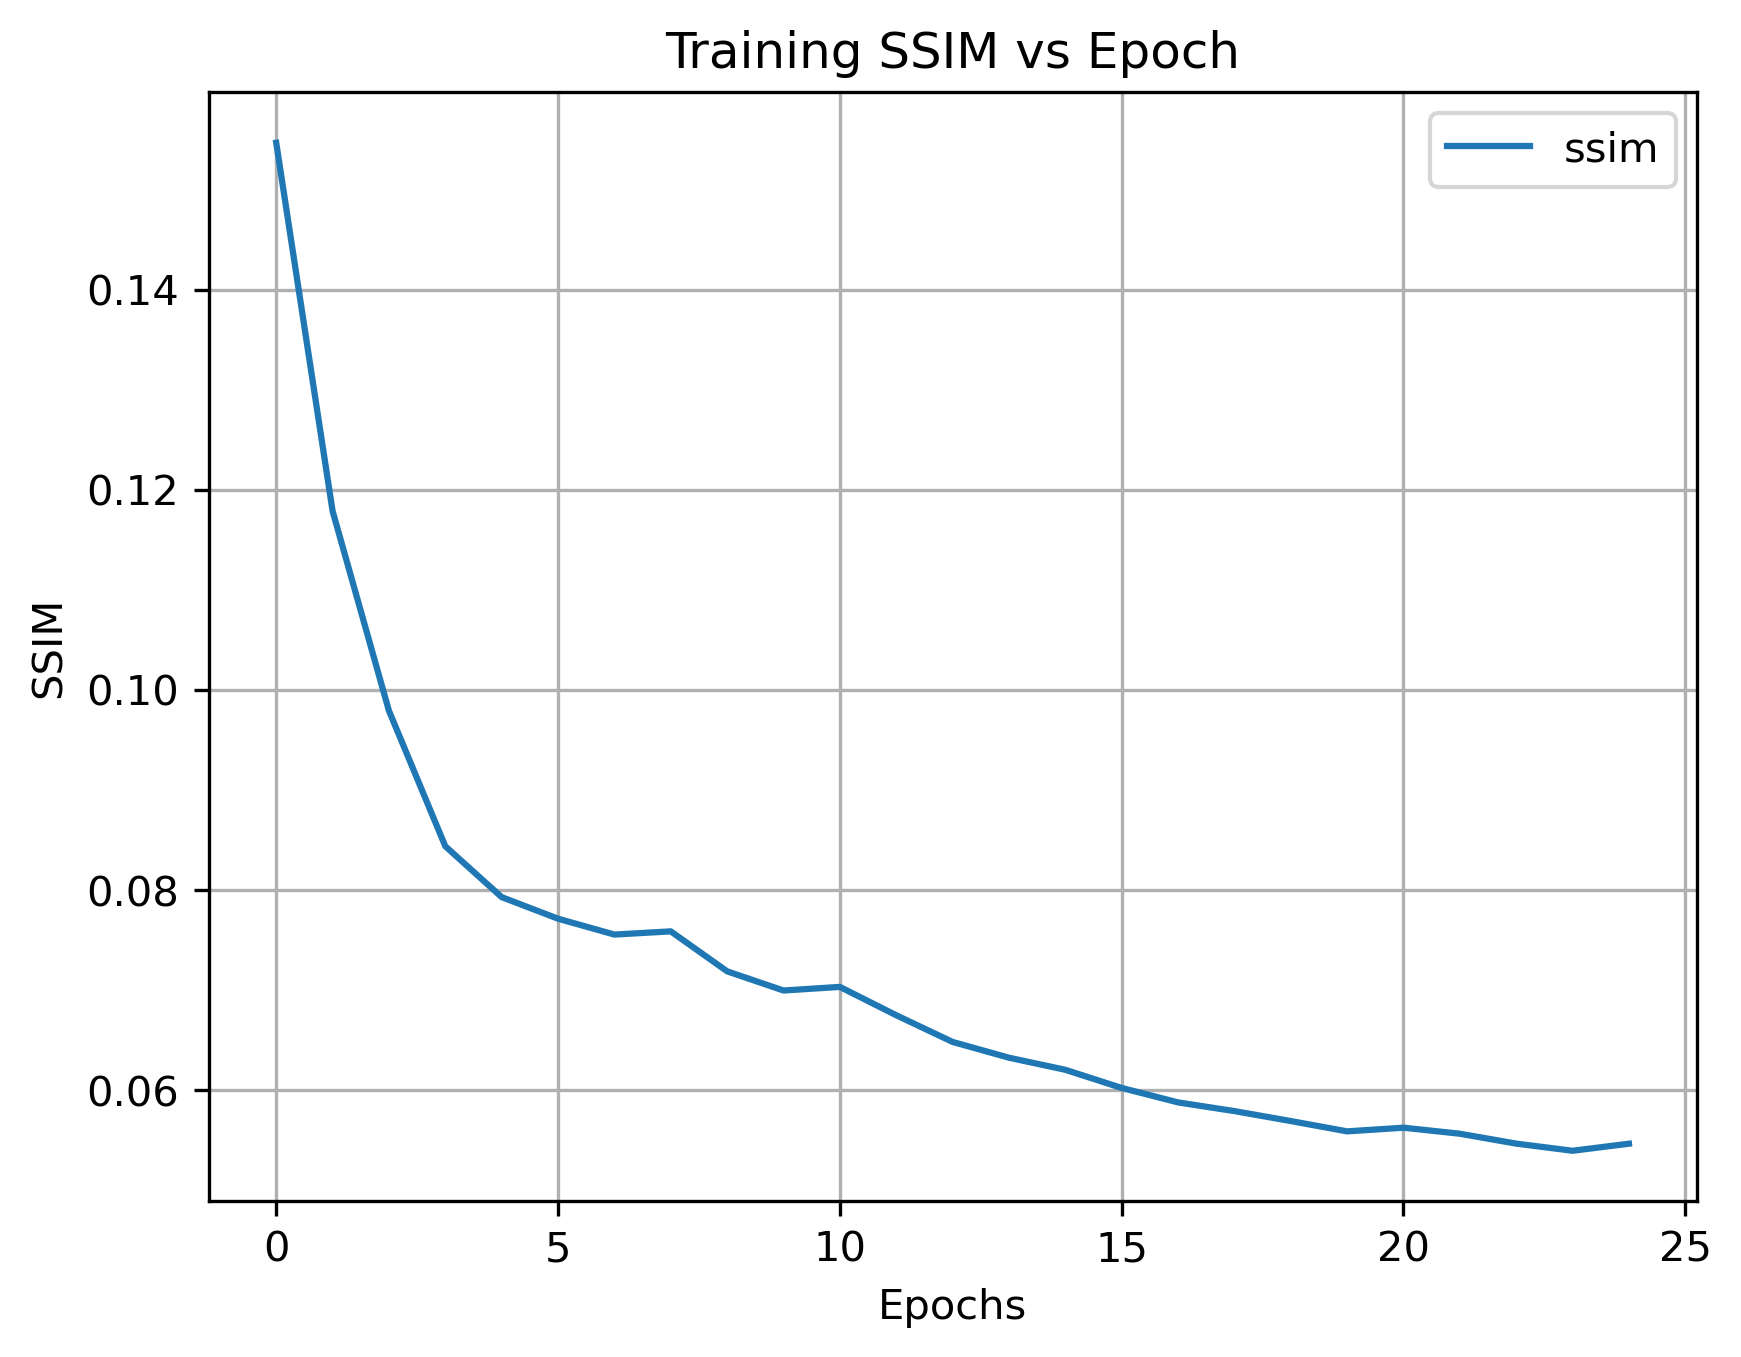

In [220]:
plt.figure(dpi=300)
plt.grid()
plt.plot(history.history['ssim__loss_11'],label='ssim')
plt.title('Training SSIM vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('trainif_SSIM.png')

In [215]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'psnr', 'ssim__loss_11', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_psnr', 'val_ssim__loss_11', 'learning_rate'])

# Testing the model


In [162]:
# !unzip 'mp2_test.zip'
import numpy as np
import matplotlib.image as mpimg

In [163]:
from PIL import Image
import os
output_folder='Final_predictions'

## Loading the test data and generating the output images and evaluation script:

In [168]:
import os
from skimage.metrics import peak_signal_noise_ratio
from skimage.io import imread

def psnr_between_folders(folder1, folder2):
    psnr_values = []
    
    # Get list of filenames in folder1
    filenames = os.listdir(folder1)
    
    for filename in filenames:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read corresponding images from both folders
            img_path1 = os.path.join(folder1, filename)
            img_path2 = os.path.join(folder2, filename)
            img1 = imread(img_path1)/255.0
            img2 = model1.predict(np.expand_dims(mpimg.imread(img_path2),axis=0))[0]
            # Save the image
            img2_pil = Image.fromarray((img2 * 255).astype(np.uint8))
            output_path = os.path.join(output_folder, filename[:-4] + '.png')  # Change the extension to PNG
            img2_pil.save(output_path)
            # Compute PSNR between corresponding images
            psnr = peak_signal_noise_ratio(img1, img2)
            psnr_values.append(psnr)
    
    # Compute average PSNR across all images
    avg_psnr = sum(psnr_values) / len(psnr_values)

    print (len(psnr_values))
    
    return avg_psnr

# Example usage:
folder1='custom_test/sharp/'
folder2 = "custom_test/blur/"

avg_psnr = psnr_between_folders(folder1, folder2)
print(f"Average PSNR between corresponding images: {avg_psnr} dB")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_1559517/884380192.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(img1, img2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [175]:
#saving final predictions:
# !zip -r 'Final_predictions.zip' 'Final_predictions'

In [228]:
image_name='00200000099.png'
image_blur = mpimg.imread(os.path.join(folder2,image_name))
image_clear= mpimg.imread(os.path.join(folder1,image_name))

pred=model.predict(np.expand_dims(image_blur,axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


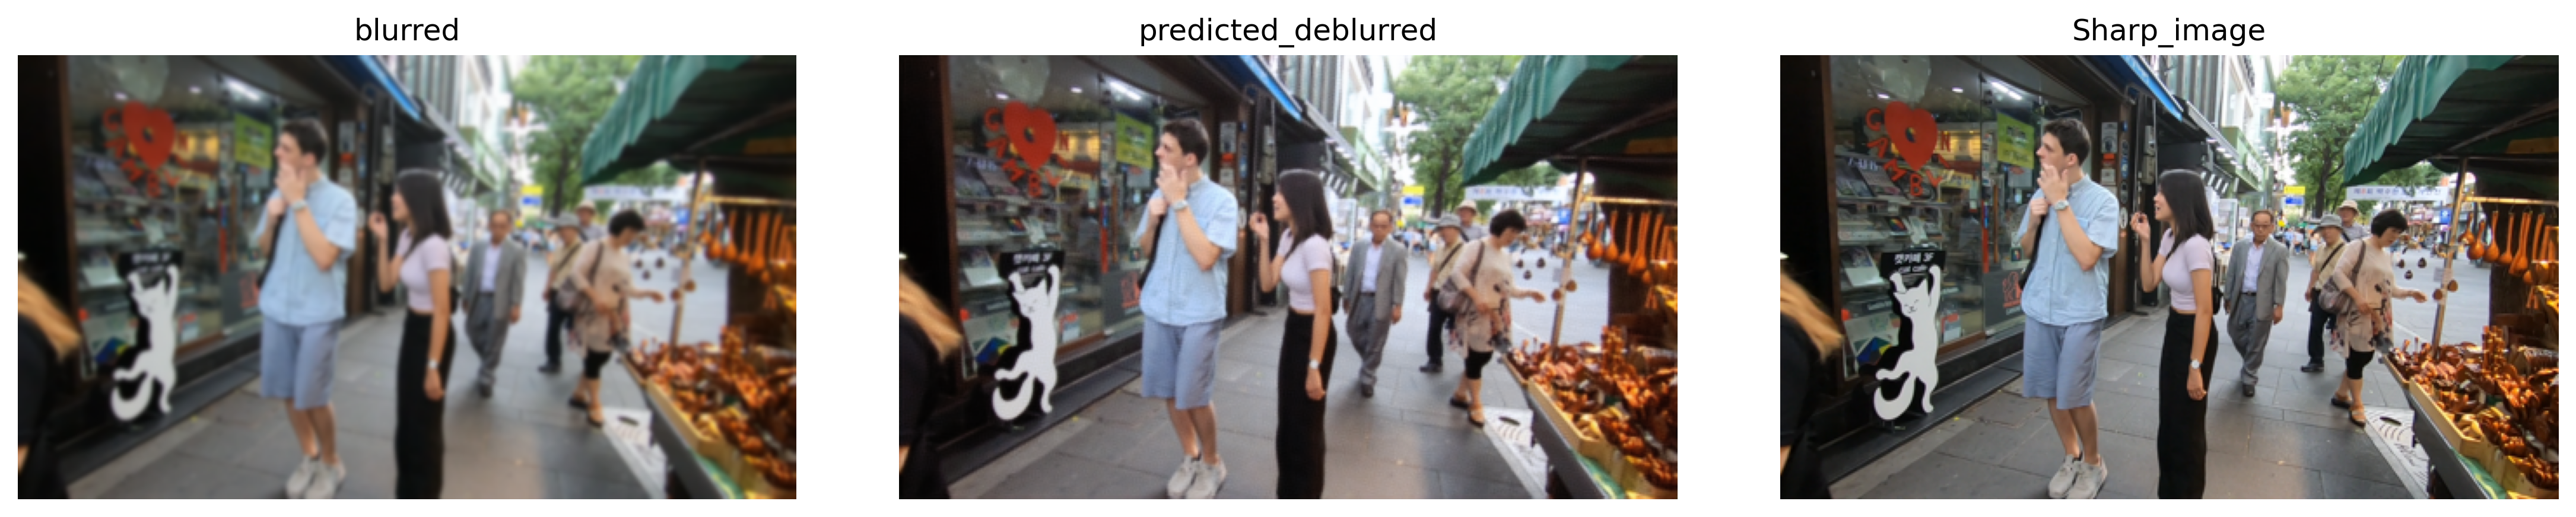

In [229]:
fig,axs=plt.subplots(1,3,figsize=(15,5),dpi=300)

plt.tight_layout()
axs[0].imshow(image_blur)
axs[0].set_title('blurred')
axs[0].axis('off')
axs[1].imshow(pred[0])
axs[1].set_title('predicted_deblurred')
axs[1].axis('off')
axs[2].imshow(image_clear)
axs[2].set_title('Sharp_image')
axs[2].axis('off')
plt.savefig('image2.png')
plt.show()

In [232]:
pred=model.predict(np.expand_dims(image_blur,axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


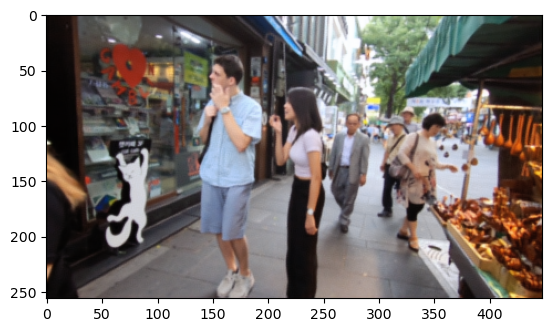

In [233]:
plt.imshow(pred[0])